In [365]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
from datetime import timedelta

import n_sphere
import tqdm
from enflows.distributions import StandardNormal, Uniform, DiagonalNormal
from enflows.transforms import Sigmoid, ScalarScale, ScalarShift, RandomPermutation, MaskedSumOfSigmoidsTransform
from enflows.transforms.normalization import ActNorm
from enflows.transforms.base import CompositeTransform, InverseTransform
from enflows.transforms.lipschitz import LipschitzDenseNetBuilder, iResBlock
from enflows.nn.nets.activations import Sin
from enflows.nn.nets import ResidualNet
from enflows.flows.base import Flow
from enflows.transforms.injective import FixedNorm, ConstrainedAnglesSigmoid

In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [3]:
def set_random_seeds (seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)

def uniform_p_norm (beta):
    return torch.ones_like(beta)

In [363]:
def spherical_to_cartesian_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    
    assert arr.shape[1] >= 2
    r = arr[:, :1]
    angles = arr[:, 1:]
    
    sin_prods = torch.cumprod(torch.sin(angles), dim=1)
    x1 = r * torch.cos(angles[:, :1])
    xs = r * sin_prods[:, :-1] * torch.cos(angles[:, 1:])
    xn = r * sin_prods[:, -1:]

    return torch.cat((x1, xs, xn), dim=1)

def cartesian_to_spherical_torch(arr):
    # meant for batches of vectors, i.e. arr.shape = (mb, n)
    assert arr.shape[1] >= 2
    radius = torch.linalg.norm(arr, dim=1)
    flipped_cumsum = torch.cumsum(torch.flip(arr ** 2, dims=(1,)), dim=1)
    sqrt_sums = torch.flip(torch.sqrt(flipped_cumsum), dims=(1,))[:,:-1]
    angles = torch.acos(arr[:, :-1] / sqrt_sums)
    last_angle = ((arr[:,-1] >= 0).float() * angles[:, -1] + \
                (arr[:,-1] < 0).float() * (2 * np.pi - angles[:, -1]))

    return torch.cat((radius.unsqueeze(1), angles[:, :-1], last_angle.unsqueeze(1)), dim=1)

In [11]:
def build_cond_flow_manifold (flow_dim, norm, q, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])
    # low = torch.tensor(-1.).to(device)
    # high = torch.tensor(1.).to(device)
    # base_dist = Uniform(shape=[flow_dim-1], low=low, high=high)

    # Define an invertible transformation
    transformation_layers = []

    for _ in range(n_layers):
        #transformation_layers.append(RandomPermutation(features=flow_dim-1))

        
        
        transformation_layers.append(
            InverseTransform(
                MaskedSumOfSigmoidsTransform(features=flow_dim-1, hidden_features=hidden_features, num_blocks=3, n_sigmoids=30)
            )
        )
        
        transformation_layers.append(
           InverseTransform(
               ActNorm(features=flow_dim-1)
           )
        )


    # transformation_layers.append(
    #    transforms.InverseTransform(
    #            ScalarScale(scale=5, trainable=False)
    #        )
    # )

    # transformation_layers.append(
    #    InverseTransform(
    #            CompositeTransform([
    #                Sigmoid(),
    #                ScalarScale(scale=20, trainable=False),
    #                ScalarShift(shift=-10, trainable=False)]
    #            )
    #        )
    # )
    
    transformation_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid(temperature=1, learn_temperature=False)
            )
    )
    
    
    transformation_layers.append(
        InverseTransform(
            FixedNorm(N=flow_dim, norm=norm, q=q)
        )
    )

    transformation_layers = transformation_layers[::-1]
    transform = CompositeTransform(transformation_layers)

    # combine into a flow
    flow = Flow(transform, base_dist).to(device)

    return flow

def build_cond_flow_lipshitz_manifold (flow_dim, norm, q, n_layers=3, hidden_features=256, device='cuda'):
    # base distribution over flattened triangular matrix
    base_dist = StandardNormal(shape=[flow_dim-1])

    densenet_builder = LipschitzDenseNetBuilder(input_channels=flow_dim-1,
                                                densenet_depth=5,
                                                activation_function=Sin(w0=30),
                                                lip_coeff=.97,
                                                )

    transform_layers = []
    for i in range(n_layers):
        transform_layers.append(InverseTransform(ActNorm(features=flow_dim-1)))
        transform_layers.append(InverseTransform(iResBlock(densenet_builder.build_network(), brute_force=False)))
    
    transform_layers.append(
        InverseTransform(
                ConstrainedAnglesSigmoid()
            )
    )
    transform_layers.append(
        InverseTransform(
            FixedNorm(N=flow_dim, norm=norm, q=q)
        )
    )

    transform_layers = transform_layers[::-1]
    transform = CompositeTransform(transform_layers)

    flow = Flow(transform, base_dist).to(device)

    return flow

In [316]:
def train_model(model, epochs=2_001, lr=1e-3, sample_size=1, device="cuda", **kwargs):

    # optimizer = torch.optim.Adam([{'params':model.parameters()}, {'params':log_sigma, 'lr':1e-2}], lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

    loss = []
    try:
        start_time = time.monotonic()
        for epoch in range(epochs):
            model.train()
            
            optimizer.zero_grad()
            q_samples, q_log_prob = model.sample_and_log_prob(num_samples=sample_size)
            if torch.any(torch.isnan(q_samples)): breakpoint()
            
            # log_lik = uniform_p_norm(beta=q_log_prob_beta)
            # kl_div = torch.mean(q_log_prob_beta - log_lik)
            # kl_div.backward()
            
            entropy = torch.mean(q_log_prob)
            entropy.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), .001)
            optimizer.step()

            # loss.append(torch.mean(q_log_prob_beta - log_lik).cpu().detach().numpy())
            loss.append(torch.mean(q_log_prob).cpu().detach().numpy())

            print(f"Training loss at step {epoch}: {loss[-1]:.4f}")
            if epoch % 25 == 0:
                
                # q_log_prob_np = q_log_prob.detach().cpu().numpy().ravel()
                # q_samples_np = q_samples.detach().cpu().numpy()
                # q_samples_theta_np = np.arctan2(q_samples_np[:,1], q_samples_np[:,0])
                # idx = np.argsort(q_log_prob_np)
                # print(q_log_prob_np[idx])
                # print(q_samples_theta_np[idx])
                # plt.scatter(q_samples_theta_np, q_log_prob_np, marker='.')
                # plt.show()
                
                q_log_prob_np = q_log_prob.detach().cpu().numpy().ravel()
                q_samples_np = q_samples.detach().cpu().numpy()
                samples_spherical = cartesian_to_spherical_torch(torch.tensor(q_samples_np)).numpy()
                for i in range(1, samples_spherical.shape[1]):
                    plt.figure(figsize=(10,5))
                    plt.scatter(samples_spherical[:,i], q_log_prob_np, marker='.')
                    plt.show()
                    
                # samples = sample_beta (flow, sample_size=10, n_iter=50, device=device)
                # samples = samples.reshape(-1,2)
                # plt.figure(figsize=(5,5))
                # plt.scatter(samples[:,0], samples[:,1], marker='.', alpha=0.3)
                # plt.xlim(-1.1, 1.1)
                # plt.ylim(-1.1, 1.1)
                # ax = plt.gca()
                # ax.set_aspect('equal', adjustable='box')
                # plt.show()

    except KeyboardInterrupt:
        print("interrupted..")

    end_time = time.monotonic()
    time_diff = timedelta(seconds=end_time - start_time)
    print(f"Training took {time_diff} seconds")

    return model, loss


In [317]:
def sample_beta (model, sample_size=100, n_iter=500, device='cuda'):
    # Sample from approximate posterior & estimate significant edges via  posterior credible interval
    samples = []
    for _ in tqdm.tqdm(range(n_iter)):
        posterior_samples, log_probs_samples = model.sample_and_log_prob(sample_size)
        samples.append(posterior_samples.cpu().detach().numpy())

    return np.concatenate(samples, 0)

In [318]:
def lp_norm(arr, p):
    norm = np.sum(np.power(np.abs(arr), p), 1)
    norm = np.power(norm, 1/p).reshape(-1,1)
    return arr/norm

def theta_given_x_y(arr):
    x_, y_ = arr[:,0], arr[:,1]
    theta_ = np.arctan2(y_,x_)
    return theta_

In [319]:
import os
dir_name = "./plots/"
if not os.path.exists(dir_name):
    # If it doesn't exist, create it
    os.makedirs(dir_name)

In [359]:
device = 'cuda'
set_random_seeds(1234)

# Build Model
flow_dim = 3
q = 1
norm = 1
flow = build_cond_flow_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)

params = dict(lr=1e-3,
              epochs=201,
              sample_size=1_000,
              device=device)

Training loss at step 0: -1.5583
torch.Size([1000])
torch.Size([1000, 2])
torch.Size([1000])


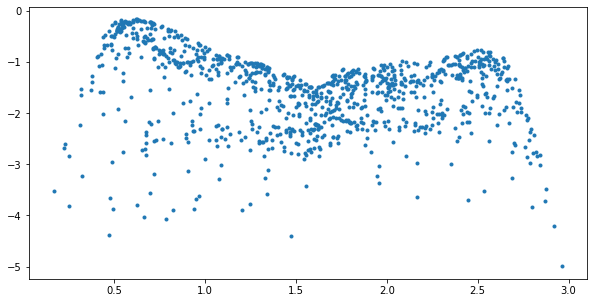

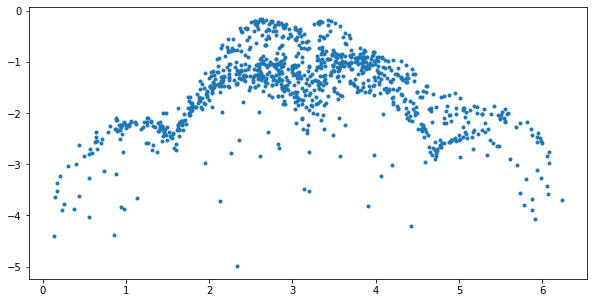

Training loss at step 1: -1.6304
Training loss at step 2: -1.7088
Training loss at step 3: -1.7638
Training loss at step 4: -1.7543
Training loss at step 5: -1.7837
Training loss at step 6: -1.8186
Training loss at step 7: -1.8194
Training loss at step 8: -1.8164
Training loss at step 9: -1.8219
Training loss at step 10: -1.8224
Training loss at step 11: -1.8258
Training loss at step 12: -1.8233
Training loss at step 13: -1.8354
Training loss at step 14: -1.8082
Training loss at step 15: -1.8226
Training loss at step 16: -1.8500
Training loss at step 17: -1.8304
Training loss at step 18: -1.8366
Training loss at step 19: -1.8306
Training loss at step 20: -1.8410
Training loss at step 21: -1.8362
Training loss at step 22: -1.8589
Training loss at step 23: -1.8402
Training loss at step 24: -1.8682
Training loss at step 25: -1.8425
torch.Size([1000])
torch.Size([1000, 2])
torch.Size([1000])


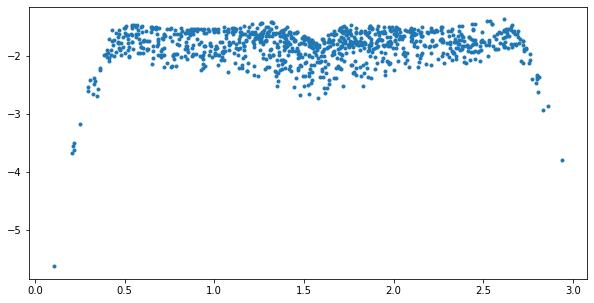

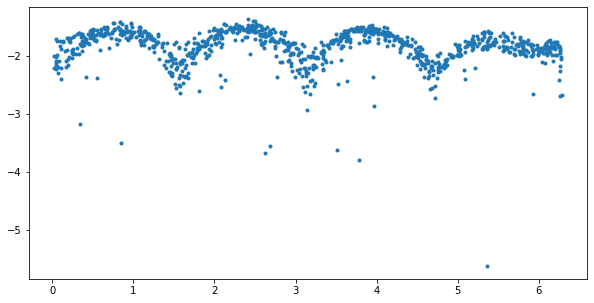

Training loss at step 26: -1.8718
Training loss at step 27: -1.8573
Training loss at step 28: -1.8604
Training loss at step 29: -1.8540
Training loss at step 30: -1.8518
Training loss at step 31: -1.8505
Training loss at step 32: -1.8458
Training loss at step 33: -1.8567
Training loss at step 34: -1.8608
Training loss at step 35: -1.8444
Training loss at step 36: -1.8496
Training loss at step 37: -1.8593
Training loss at step 38: -1.8785
Training loss at step 39: -1.8646
Training loss at step 40: -1.8728
Training loss at step 41: -1.8598
Training loss at step 42: -1.8534
Training loss at step 43: -1.8646
Training loss at step 44: -1.8745
Training loss at step 45: -1.8575
Training loss at step 46: -1.8561
Training loss at step 47: -1.8845
Training loss at step 48: -1.8729
Training loss at step 49: -1.8872
Training loss at step 50: -1.8946
torch.Size([1000])
torch.Size([1000, 2])
torch.Size([1000])


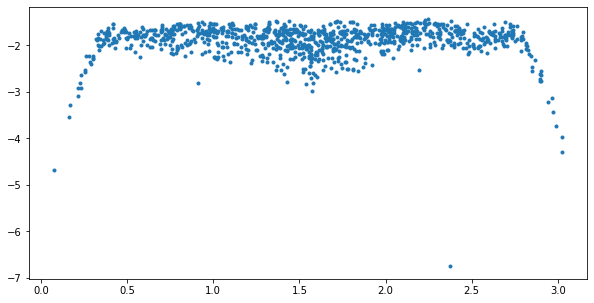

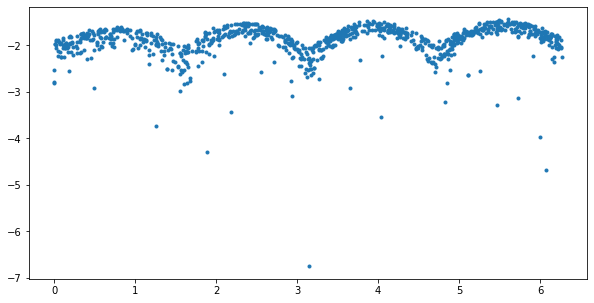

Training loss at step 51: -1.8632
Training loss at step 52: -1.8652
Training loss at step 53: -1.8785
Training loss at step 54: -1.8644
Training loss at step 55: -1.8939
Training loss at step 56: -1.8729
Training loss at step 57: -1.8779
Training loss at step 58: -1.8979
Training loss at step 59: -1.8750
Training loss at step 60: -1.8774
Training loss at step 61: -1.8847
Training loss at step 62: -1.8912
Training loss at step 63: -1.8720
Training loss at step 64: -1.8795
Training loss at step 65: -1.8806
Training loss at step 66: -1.8790
Training loss at step 67: -1.8797
Training loss at step 68: -1.8980
Training loss at step 69: -1.8900
Training loss at step 70: -1.8791
Training loss at step 71: -1.8889
Training loss at step 72: -1.8743
Training loss at step 73: -1.8872
Training loss at step 74: -1.8794
Training loss at step 75: -1.8848
torch.Size([1000])
torch.Size([1000, 2])
torch.Size([1000])


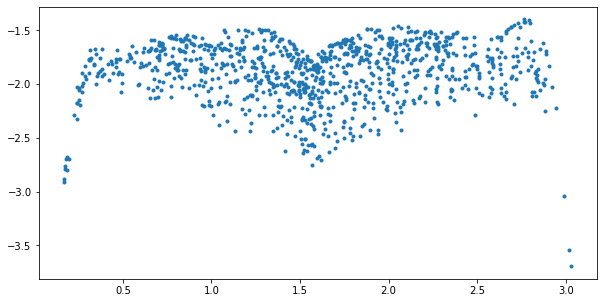

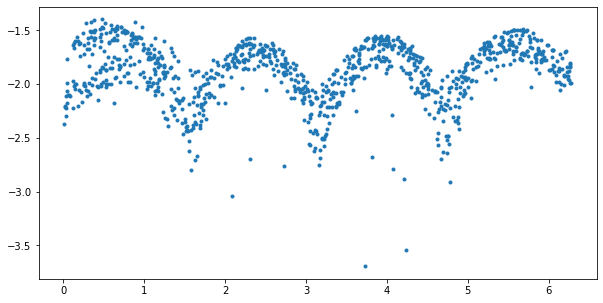

Training loss at step 76: -1.8716
Training loss at step 77: -1.8901
Training loss at step 78: -1.8819
Training loss at step 79: -1.8960
Training loss at step 80: -1.8903
Training loss at step 81: -1.8880
Training loss at step 82: -1.8738
Training loss at step 83: -1.9013
Training loss at step 84: -1.8893
Training loss at step 85: -1.8955
Training loss at step 86: -1.8890
Training loss at step 87: -1.9054
Training loss at step 88: -1.9118
Training loss at step 89: -1.8962
Training loss at step 90: -1.8890
Training loss at step 91: -1.8874
Training loss at step 92: -1.8887
Training loss at step 93: -1.9104
Training loss at step 94: -1.8912
Training loss at step 95: -1.8920
Training loss at step 96: -1.8939
Training loss at step 97: -1.8904
Training loss at step 98: -1.8953
Training loss at step 99: -1.8954
Training loss at step 100: -1.9004
torch.Size([1000])
torch.Size([1000, 2])
torch.Size([1000])


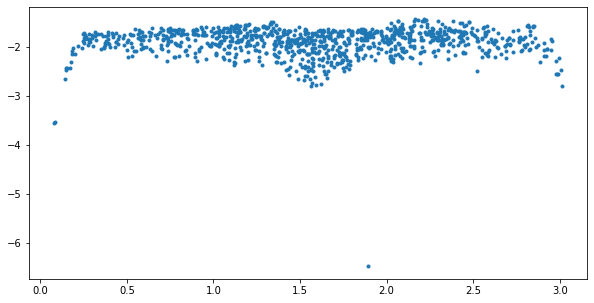

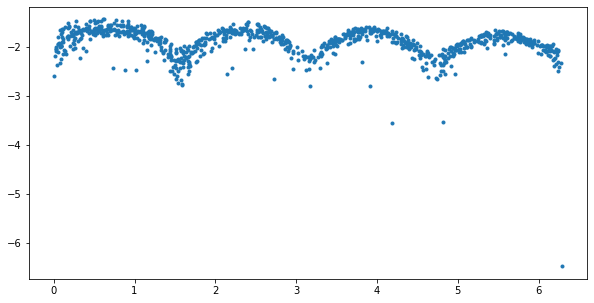

Training loss at step 101: -1.8895
interrupted..
Training took 0:03:23.084874 seconds


Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): InverseTransform(
        (_transform): FixedNorm(
          (sph_to_cart_jac): SymPyModule(expressions=(-r*sin(theta_1), 0, cos(theta_1), r*cos(theta_1)*cos(theta_2), -r*sin(theta_1)*sin(theta_2), sin(theta_1)*cos(theta_2), r*sin(theta_2)*cos(theta_1), r*sin(theta_1)*cos(theta_2), sin(theta_1)*sin(theta_2)))
        )
      )
      (1): InverseTransform(
        (_transform): ConstrainedAnglesSigmoid(
          (elemwise_transform): CompositeTransform(
            (_transforms): ModuleList(
              (0): Sigmoid()
              (1): ScalarScale()
            )
          )
        )
      )
      (2): InverseTransform(
        (_transform): ActNorm()
      )
      (3): InverseTransform(
        (_transform): MaskedSumOfSigmoidsTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=2, out_features=64, bias=True)
            (blocks): ModuleList(
      

In [360]:
flow, loss = train_model(flow, **params)
flow.eval()

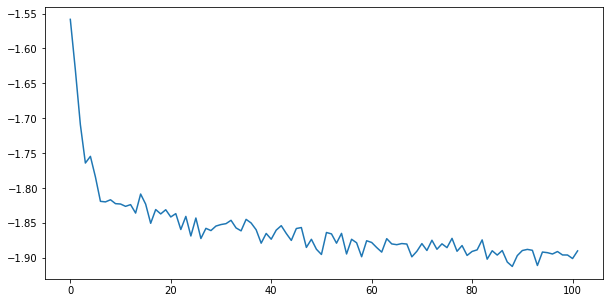

In [361]:
plt.figure(figsize=(10,5))
plt.plot(range(len(loss)), loss)
plt.show()

In [362]:
n_samples = 50_000
n_samples_plot = 1000
samples = sample_beta (flow, sample_size=n_samples//20, n_iter=20, device=device)
samples_reshaped = samples.reshape(-1, flow_dim)

100%|██████████| 20/20 [01:39<00:00,  4.95s/it]


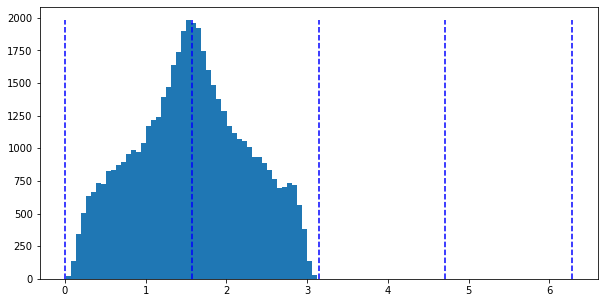

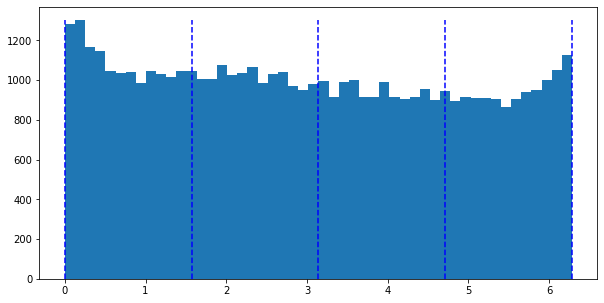

In [364]:
# fig = plt.figure(figsize=(7,7))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(samples_[:n_samples_plot,0], samples_[:n_samples_plot,1], samples_[:n_samples_plot,2], marker='.', alpha=0.5)
# ax_min, ax_max = -1.1, 1.1
# ax.set_xlim3d(ax_min, ax_max)
# ax.set_ylim3d(ax_min, ax_max)
# ax.set_zlim3d(ax_min, ax_max)
# #plt.savefig(f"{dir_name}samples_p{q}_flow.pdf", dpi=100)
# plt.show()

samples_spherical = cartesian_to_spherical_torch(torch.tensor(samples)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
    # plt.savefig(f"{dir_name}samples_p{q}_theta_flow.pdf", dpi=100)
    plt.show()

In [357]:
from rpy2.robjects.packages import importr
rpgnorm = importr('pgnorm')
%R -i q -i flow_dim -i n_samples -o samples samples <- rpgnorm(n_samples * flow_dim, q)
samples = np.array(samples).reshape(-1,flow_dim)
samples_norm = lp_norm(samples, q)

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


torch.Size([50000])
torch.Size([50000, 2])
torch.Size([50000])


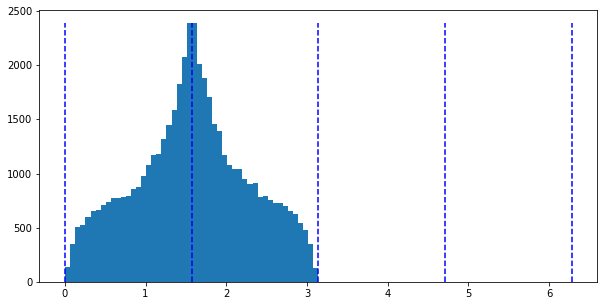

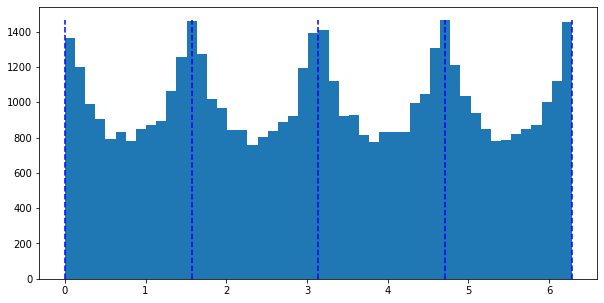

In [358]:
# fig = plt.figure(figsize=(7,7))
# ax = fig.add_subplot(projection='3d')
# ax.scatter(samples_norm[:n_samples_plot,0], samples_norm[:n_samples_plot,1], samples_norm[:n_samples_plot,2], marker='.', alpha=0.5)
# ax_min, ax_max = -1.1, 1.1
# ax.set_xlim3d(ax_min,ax_max)
# ax.set_ylim3d(ax_min,ax_max)
# ax.set_zlim3d(ax_min,ax_max)
# #ax = plt.gca()
# #ax.set_aspect('equal', adjustable='box')
# #plt.savefig(f"{dir_name}samples_p{q}_gt.pdf", dpi=100)
# plt.show()


samples_spherical = cartesian_to_spherical_torch(torch.from_numpy(samples_norm)).numpy()
for i in range(1, samples_spherical.shape[1]):
    plt.figure(figsize=(10,5))
    n, bins, patches = plt.hist(samples_spherical[:,i], bins=50)
    plt.vlines([0, np.pi * 0.5, np.pi, np.pi*1.5, 2 * np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
    # plt.savefig(f"{dir_name}samples_p{q}_theta_gt.pdf", dpi=100)
    plt.show()

In [135]:
sol_2 = n_sphere.convert_rectangular(n_sphere.convert_spherical(samples_norm))

100%|██████████| 20/20 [00:53<00:00,  2.67s/it]


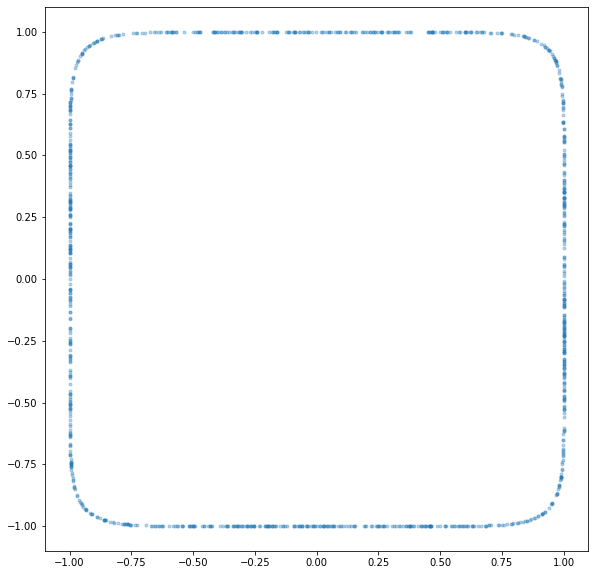

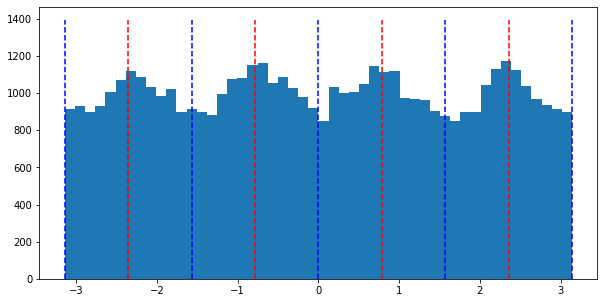

In [446]:
n_samples = 50_000
n_samples_plot = 1000
samples = sample_beta (flow, sample_size=n_samples//20, n_iter=20, device=device)
samples = samples.reshape(-1,2)
plt.figure(figsize=(10,10))
plt.scatter(samples[:n_samples_plot,0], samples[:n_samples_plot,1], marker='.', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig(f"{dir_name}samples_p{q}_flow.pdf", dpi=100)
plt.show()

theta_ = theta_given_x_y(samples)
plt.figure(figsize=(10,5))
plt.hist(theta_, bins=50)
plt.vlines([-np.pi * 0.75, -np.pi * 0.25, np.pi * 0.25, np.pi * 0.75], ymin=0, ymax=max(n), linestyles='dashed', colors='r')
plt.vlines([-np.pi, -np.pi * 0.5, 0, np.pi * 0.5, np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
plt.savefig(f"{dir_name}samples_p{q}_theta_flow.pdf", dpi=100)
plt.show()

In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages


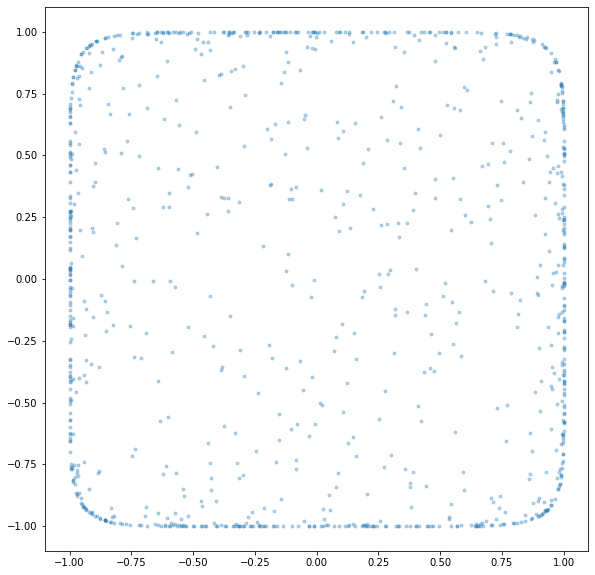

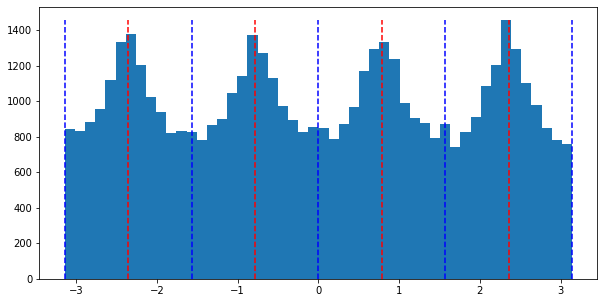

In [485]:
from rpy2.robjects.packages import importr
flow_dim = 3
rpgnorm = importr('pgnorm')
%R -i q -i flow_dim -i n_samples -o samples samples <- rpgnorm(n_samples * flow_dim, q)
samples = np.array(samples).reshape(-1,flow_dim)
samples_norm = lp_norm(samples, q)
plt.figure(figsize=(10,10))
plt.scatter(samples_norm[:n_samples_plot,0], samples_norm[:n_samples_plot,1], marker='.', alpha=0.3)
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.savefig(f"{dir_name}samples_p{q}_gt.pdf", dpi=100)
plt.show()

plt.figure(figsize=(10,5))
theta_ = theta_given_x_y(samples_norm)
n, bins, patches = plt.hist(theta_, bins=50)
plt.vlines([-np.pi * 0.75, -np.pi * 0.25, np.pi * 0.25, np.pi * 0.75], ymin=0, ymax=max(n), linestyles='dashed', colors='r')
plt.vlines([-np.pi, -np.pi * 0.5, 0, np.pi * 0.5, np.pi], ymin=0, ymax=max(n), linestyles='dashed', colors='b')
plt.savefig(f"{dir_name}samples_p{q}_theta_gt.pdf", dpi=100)
plt.show()